In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [0]:
bs = 64 #batch size

In [0]:
path = untar_data(URLs.PETS)/'images'
path

PosixPath('/root/.fastai/data/oxford-iiit-pet/images')

## Data Augmentation

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4, 
                      p_affine=1., p_lighting=1.)

In [0]:
doc(get_transforms) #taking a look at the fastai docs

In [0]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [0]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
            .transform(tfms, size=size, padding_mode=padding_mode)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

In [0]:
data = get_data(224, bs, 'zeros') #Zero padding in ConvNets is highly suspicious/wrong. Input distribution stats are off on each border differently yet params are all shared.
data

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Birman,great_pyrenees,boxer,Egyptian_Mau,Russian_Blue
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Sphynx,miniature_pinscher,yorkshire_terrier,wheaten_terrier,american_pit_bull_terrier
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

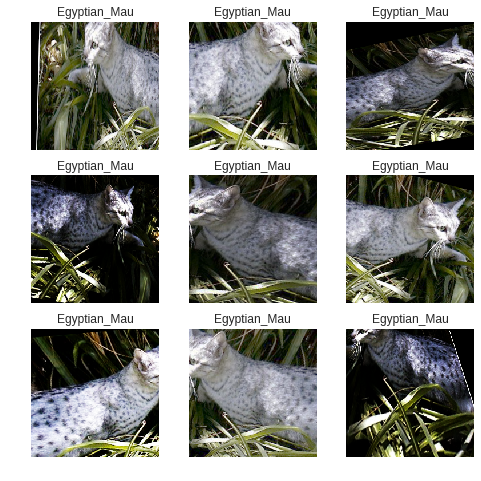

In [0]:
def _plot(i, j, ax):
    x, y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8)) 
#is going to create a 3 by 3 grid of plots, and each one will contain the result of calling this (_plot) function which will receive the plot coordinates and the axis

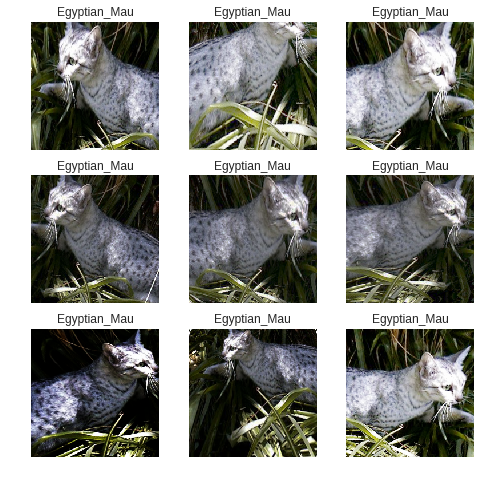

In [0]:
data = get_data(224,bs)
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [0]:
gc.collect() #use memory
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 97759032.35it/s]


In [0]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.359107,1.022238,0.206360,02:04
1,1.378324,0.343291,0.091340,02:04
2,0.881086,0.276652,0.077808,02:02


In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.678720,0.284556,0.069689,02:09
1,0.618270,0.293644,0.075101,02:11


In [0]:
data = get_data(352, bs) #we are going to train the model with a larger dataset
learn.data = data

In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.587185,0.266313,0.053451,03:55
1,0.561804,0.265034,0.054127,03:55


In [0]:
learn.save('352')

# Convolution kernel

In [0]:
data = get_data(352, 16)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category Sphynx

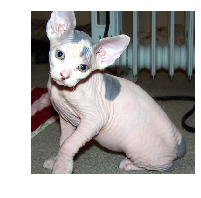

In [0]:
idx=0
x,y = data.valid_ds[idx]
x.show() #show image
data.valid_ds.y[idx] #show label

In [0]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6 #expand is copying our kernel times we've specified
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [0]:
k.shape

torch.Size([1, 3, 3, 3])

In [0]:
t = data.valid_ds[0][0].data #first part of the validation dataset
t.shape

torch.Size([3, 352, 352])

In [31]:
t[None].shape #

torch.Size([1, 3, 352, 352])

In PyTorch, pretty much everything is expecting to work on a mini-batch, not on an individual thing. So in our case, we have to create a mini-batch of size 1.

Our original image is 3 channels by 352 by 352 (height by width). We need to create a rank 4 tensor where the first axis is 1. In other words, it's a mini batch of size 1, because that's what PyTorch expects.

So there's something we can do in both PyTorch and numpy which is we can index into an array or a tensor with a special value None, and that creates a new unit axis in that point.

Now, t[None] is a rank 4 tensor, a mini batch of one image of 1 by 3 by 352 by 352

In [0]:
edge = F.conv2d(t[None], k)

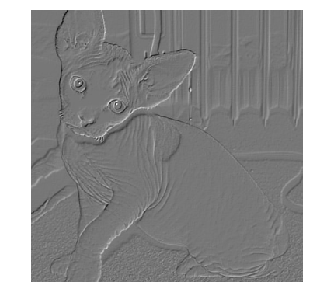

In [36]:
show_image(edge[0], figsize=(5,5));

## Creating a heatmap

In [37]:
data.c #the length of this is gonna be our output channel , the probability of everyone of this classes

37

In [38]:
learn.model #here we can see we have 37 features (output = features)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [39]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
______________________________________________________________

## Heatmap

In [0]:
m = learn.model.eval() # .eval() will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval model instead of training mode

In [41]:
m

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
xb,_ = data.one_item(x) #it creates a mini batch with one thing in it
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [0]:
from fastai.callbacks.hooks import *

In [0]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [0]:
hook_a,hook_g = hooked_backward()

In [46]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [47]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [0]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

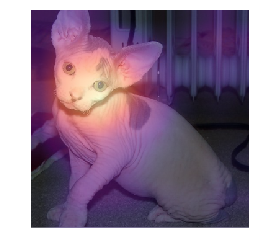

In [49]:
show_heatmap(avg_acts)